# Busca e classificação ordenada (ranking) TEC 

### Recuperação e Ranqueamento de Texto, Análise de Dados e Aprendizagem Supervisionada com base no texto da Tarifa Externa Comum do Mercosul

#### Resumo

Utilização das técnicas word2vec, BagofWords, unigrama, bigrama, totemização, text similarity, OkapiBM25+, entre outras, para processamento dos subitens passíveis de utilização para sugestão de classificação fiscal conforme descrito no texto da TEC Mercosul e ranqueamento com relação a uma lista de palavras buscadas. Comparação com métodos de aprendizado de máquina.

### Introdução

A Classificação Fiscal correta é sempre um desafio. As edições brasileiras do texto da Tarifa Externa Comum tem dezenas de milhares de palavras, uma centena de capítulos, mais de 10.000 subitens passíveis de uso para classificação, uma hierarquia complexa e nem sempre uniforme, além de Notas de Seção, Notas de Capítulo, Regras gerais, etc. Neste trabalho é proposto o uso computadores para levantar estes números exatos para nós, pois nisso os computadores já superam os seres humanos ( e com os últimos avanços em IA e Aprendizado de máquina -AI Machine Learning e Deep Learning estão começando a nos alcançar no processamento estatístico de textos e na visão e reconhecimento de objetos, em alguns casos superando).

Este artigo está estruturado em várias partes, relativamente independentes.

Análise do texto da TEC e considerações sobre o desafio da Classificação Fiscal. Primeiros processamentos de texto e escolha de um caminho.

Testes e estatísticas na linguagem de programação Python(com código). Aplicação das técnicas de vetorização, bigrama, stemização, Query similarity e OkapiBM25+.

Testes de modelos de aprendizado estatístico para tarefa similar.

## Importar bibliotecas necessárias

In [1]:
import numpy as np
import nltk
import sklearn
import sys

sys.path.insert(0, '..')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Parte 1 - Ler TEC e montar documentos

Abrindo a TEC no Word, podemos começar a analisar sua estrutura. Basicamente, ela possui seis partes:

* Títulos de Seções e Capítulos
* Abreviaturas e Símbolos
* Regras Gerais para Interpretação do Sistema Harmonizado
* Regras Gerais Complementares
* Regra de Tributação para Produtos do Setor Aeronáutico
* Nomenclatura Comum do MERCOSUL (NCM) e Regime Tarifário Comum

Para nosso trabalho, o importante é a sexta parte, que por sua vez assim se divide:

* Seção (Descrição)
* Notas de Seção
* Capítulo (Descrição)
* Notas de Capítulo
* Tabela NCM, Descrição, TEC

Cabe aqui um adendo e uma observação importante: a tarefa de classificação fiscal é um trabalho técnico, que pode depender de outras informações e conhecimentos específicos, que não estarão escritos no texto da TEC, como por exemplo conhecimentos sobre metalurgia, química ou têxteis. Além também de conhecimento sobre as regras de classificação fiscal (descritas na TEC), interpretação gramatical e legal, decomposição do produto caso misto, entre outros. Por isso a legislação determinou competência à autoridade tributária (O Auditor Fiscal em exercício na Receita Federal) em termos de decisão em classificação fiscal de mercadorias ( artigo 15, inciso XIX, do Decreto 7.482/11 e INSTRUÇÃO NORMATIVA RFB Nº 1464, DE 08 DE MAIO DE 2014, entre outros).

Cabe lembrar também que o que ora chamamos de “TEC” é uma compilação de tratados, tradições, estudos técnicos e padrões internacionais compilados primeiramente no sistema harmonizado internacional (SH) na chamada Convenção Internacional de Bruxelas, com chancela da OMA (Organização Mundial das Aduanas) e depois expandidos para a experiência e necessidades do Mercosul NCM — Mercado Comum do Mercosul Nomenclatura Comum de Mercadorias. Além disso, no Brasil, vigoram também regras federais adicionais do RIPI — Regulamento do Imposto sobre Produtos Industrializados bem como regulamentos do ICMS — Estaduais.

A solução, no âmbito deste trabalho, é fazer uma “pontuação” dos subitens da TEC e exibir os resultados em ordem decrescente. Afinal, são mais de 10.000 possibilidades. Então faremos o computador passar o que podemos chamar de uma “peneira grossa” e analisaremos apenas umas poucas posições melhor ranqueadas. Talvez precisemos analisar apenas as três ou quatro primeiras da lista se tivermos “sorte”.

Por “sorte”, podemos definir a pergunta “certa” também. No caso, a pergunta seria a descrição da mercadoria que se quer classificar. Assim, a autoridade (Auditor Fiscal), o Importador, o Fabricante, o Assistente Técnico, Despachante Aduaneiro, preposto, ou outro que possua a responsabilidade de descrever a mercadoria deve fazê-lo de modo a permitir identificar corretamente o produto e definir sua correta classificação fiscal (IN RFB 680/2006 e Regulamento Aduaneiro Art. 711, entre outros).

Em resumo, podemos didaticamente então “fatiar” a tarefa classificação fiscal em duas etapas: 1. Descrever o produto; 2. Encaixar a descrição na classificação correta. Como a TEC/NCM é hierárquica, podemos fazer uma analogia com uma árvore. Normalmente, percorremos os ramos desta árvore em busca do posicionamento correto. Mas há possibilidade de estarmos olhando para um ramo e o item correto estar em outro, e não o enxergarmos por estarmos no ramo errado usando um subitem muito parecido. Superar esta busca hierárquica é o objetivo deste sistema.

Fazendo outra analogia, pensemos em um egiptólogo: no passo 1 ele define exatamente o artefato que a expedição irá buscar, e descreve, através de pesquisas anteriores, o caminho: Como é o artefato, em que sítio arqueológico estaria, etc. O segundo passo é a expedição propriamente dita. Nesta, a equipe se enreda por galerias, túneis, etc. E pode achar um artefato MUITO parecido em uma câmara, mas não olhar na câmara vizinha, onde está o artefato realmente procurado. Para evitar esta situação, nosso robô percorrerá todas as câmaras e pontuará os artefatos encontrados de acordo com a similaridade com o artefato descrito no primeiro passo.
Esta pontuação será baseada em uma relação de similaridade entre uma frase que descreve o que se busca e cada um dos subitens da TEC.

No caso da classificação fiscal há um terceiro passo ainda, pois uma posição ou capítulo ou outro pode ser excluído ou pode haver uma condicional imposta por uma nota de seção ou capítulo ou outro tipo de exceção, como uma das regras gerais. Esta tarefa poderia ser passível de automatização também através de técnicas de NLP, mas ainda não é o escopo deste trabalho.

Agora, o que podemos entender por “subitens da TEC”.
Analisando a parte “Tabela NCM, Descrição, TEC”, vemos que nem todas as linhas possuem valor na coluna “TEC”:

Primeira página da TEC, versão Word. Note-se a terceira coluna da tabela

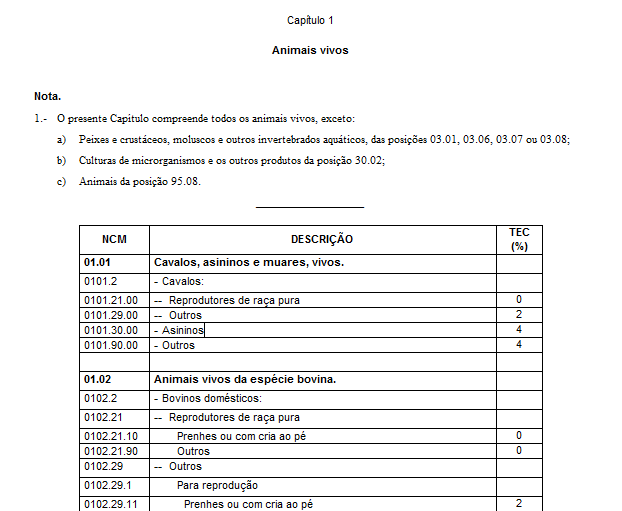

In [2]:
from IPython.display import Image
Image("img/tec.png")

Na tela, notamos facilmente a estrutura antes descrita (Capítulo XX (Descrição), Notas de Capítulo, Tabela NCM. Também notamos que apenas algumas linhas da tabela possuem valores na terceira coluna (TEC %).
Ocorre que a estrutura da NCM é hierarquizada, na sequência do SH: Capítulo(2 dígitos), Posição(4 dígitos), Subposição 1 e 2( 5 e 6 dígitos). O Mercosul adiciona ainda mais dois dígitos: Item e Subitem (7º e 8º dígitos respectivamente). Apenas a linha completa, de maior ordem, contendo uma alíquota TEC (assim como nos textos próprios alíquotas de IPI e ICMS) pode ser usada para classificação fiscal.

Mas, olhando novamente na tabela, vemos que o campo descrição nestas linhas normalmente é espartano. Por exemplo, o subitem NCM 0102.21.10 fala apenas em “prenhes ou com cria ao pé” e, pior, o seguinte, 0102.21.90, apenas “Outros”.

Assim, vamos criar um conceito chamado “Lista TEC com descrição completa”. Desta forma, cada subposição, item ou subitem deve ser descrito com a concatenação da sua árvore hieráquica. Assim, sabemos que o subitem 0102.21.10 refere-se a “Animais vivos da espécie bovina — Bovinos domésticos — Reprodutores de raça pura Prenhes com cria ao pé” e o subitem 0102.31.90 refere-se a “Animais vivos da espécie bovina — Búfalos — Reprodutores de raça pura Outros”. Certamente bem mais informativo que antes. Podemos ainda pensar em somar as descrições dos Capítulos nesta hierarquia.

Embora cada linha fique mais informativa, a quantidade total de palavras a ser buscada ficará muito maior, pois muitas se repetirão. Além disso, a quantidade de palavras em algumas descrições da tabela já é grande por si só, e concatenar com mais descrições tornará tudo maior. Mas não podemos perder o foco: o objetivo é produzir linhas para que o computador, e não seres humanos, procurem e contem ocorrências de palavras. E nisso os computadores são imensamente melhores que nós, seres humanos. Esta linha que está sendo proposta será “digerida” e (pré)processada por máquinas digitais, que retornarão ao ser humano apenas o “filé” que este busca dentre as mais de 10.000 opções.

Foram criadas algumas funções/scripts para fazer este pré-processamento, conforme abaixo:

In [3]:
import batch.processtec as pt

listaTEC = pt.leTEC()
print('Texto original do arquivo:')
print(listaTEC[:60])


Texto original do arquivo:
['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'NOMENCLATURA COMUM DO MERCOSUL (NCM)\n', 'E TARIFA EXTERNA COMUM (TEC)\n', 'BRASIL \n', '2 0 1 7\n', 'Atualizada até a Resolução Camex nº 15 de 17/02/2017 (DOU 21/02/2017)\n', '\n', '(Baseada no Sistema Harmonizado de Designação e de \n', 'Codificação de Mercadorias, atualizado com sua VI Emenda)\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'CONTEÚDO\n', '\n', '\n', '\n', '\n', 'Títulos de Seções e Capítulos\n', 'Abreviaturas e Símbolos\n', 'Regras Gerais para Interpretação do Sistema Harmonizado\n', 'Regras Gerais Complementares\n', 'Regra de Tributação para Produtos do Setor Aeronáutico\n', 'Nomenclatura Comum do MERCOSUL (NCM) e Regime Tarifário Comum\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'Notas.\n', '\n', 'Na Nomenclatura, os termos e expressões seguidos de um asterisco e que constam entre parênteses, são equivalen

In [4]:
listaNCM = pt.montaNCM(listaTEC)
print('Linhas originais da tabela da TEC:')
for itemTEC in listaNCM[:10]:
    print(itemTEC)

Linhas originais da tabela da TEC:
['01.01', 'Cavalos, asininos e muares, vivos.', '']
['0101.2', '-\tCavalos:', '']
['0101.21.00', '--\tReprodutores de raça pura', '0']
['0101.29.00', '--\tOutros', '2']
['0101.30.00', '-\tAsininos', '4']
['0101.90.00', '-\tOutros', '4']
['01.02', 'Animais vivos da espécie bovina.', '']
['0102.2', '-\tBovinos domésticos:', '']
['0102.21', '--\tReprodutores de raça pura', '']
['0102.21.10', 'Prenhes ou com cria ao pé', '0']


In [5]:
listaTECResumo = pt.montaTECResumo(listaNCM)
print('TEC Resumo - linhas dos subitens com descrição dos nós pais incluída:')
for itemTEC_descricao_completa in listaTECResumo[:10]:
    print(itemTEC_descricao_completa)

TEC Resumo - linhas dos subitens com descrição dos nós pais incluída:
0101.21.00 --	Reprodutores de raça pura -	Cavalos: Cavalos, asininos e muares, vivos.
0101.29.00 --	Outros -	Cavalos: Cavalos, asininos e muares, vivos.
0101.30.00 -	Asininos Cavalos, asininos e muares, vivos.
0101.90.00 -	Outros Cavalos, asininos e muares, vivos.
0102.21.10 Prenhes ou com cria ao pé --	Reprodutores de raça pura -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.21.90 Outros --	Reprodutores de raça pura -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.11 Prenhes ou com cria ao pé Para reprodução --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.19 Outros Para reprodução --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.90 Outros --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.31.10 Prenhes ou com cria ao pé --	Reprodutores de raça pura -	Búfalos: Animais vivos da espécie bovina.


In [6]:
corpus = []

for itemTEC_descricao_completa in listaTECResumo:
    documento = pt.tokenize_to_words(itemTEC_descricao_completa)
    corpus.append(' '.join(documento[1:]))

In [7]:
print('Corpus - descrição completa sem stopwords, sem caracteres especias e pontuação, somente minúsculas')
corpus[:100]

Corpus - descrição completa sem stopwords, sem caracteres especias e pontuação, somente minúsculas


['reprodutores raca pura cavalos cavalos asininos muares vivos',
 'outros cavalos cavalos asininos muares vivos',
 'asininos cavalos asininos muares vivos',
 'outros cavalos asininos muares vivos',
 'prenhes cria reprodutores raca pura bovinos domesticos animais vivos especie bovina',
 'outros reprodutores raca pura bovinos domesticos animais vivos especie bovina',
 'prenhes cria para reproducao outros bovinos domesticos animais vivos especie bovina',
 'outros para reproducao outros bovinos domesticos animais vivos especie bovina',
 'outros outros bovinos domesticos animais vivos especie bovina',
 'prenhes cria reprodutores raca pura bufalos animais vivos especie bovina',
 'outros reprodutores raca pura bufalos animais vivos especie bovina',
 'prenhes cria para reproducao outros bufalos animais vivos especie bovina',
 'outros para reproducao outros bufalos animais vivos especie bovina',
 'outros outros bufalos animais vivos especie bovina',
 'outros animais vivos especie bovina',
 'rep

In [8]:
listaCapitulos = pt.montaCapitulos(listaTEC)
for capitulo in listaCapitulos[:3]:
    print(capitulo)

['Capítulo 1', 'Animais vivos', '1.-\tO presente Capítulo compreende todos os animais vivos, exceto:\n\na)\tPeixes e crustáceos, moluscos e outros invertebrados aquáticos, das posições 03.01, 03.06, 03.07 ou 03.08;\n\nb)\tCulturas de microrganismos e os outros produtos da posição 30.02;\n\nc)\tAnimais da posição 95.08.\n\n']
['Capítulo 2', 'Carnes e miudezas, comestíveis', '1.-\tO presente Capítulo não compreende:\n\na)\tNo que diz respeito às posições 02.01 a 02.08 e 02.10, os produtos impróprios para alimentação humana;\n\nb)\tAs tripas, bexigas e estômagos, de animais (posição 05.04), nem o sangue animal (posições 05.11 ou 30.02);\n\nc)\tAs gorduras animais, exceto os produtos da posição 02.09 (Capítulo 15).\n\n']
['Capítulo 3', 'Peixes e crustáceos, moluscos e \n outros invertebrados aquáticos', '1.-\tO presente Capítulo não compreende:\n\na)\tOs mamíferos da posição 01.06;\n\nb)\tAs carnes dos mamíferos da posição 01.06 (posições 02.08 ou 02.10);\n\nc)\tOs peixes (incluindo os seu

## Usar sklearn para montar o DTM

Utilizando scikit-learn, montar Bag of Words do Corpus criado

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')

X = vectorizer.fit_transform(corpus)

In [10]:
len(vectorizer.get_feature_names())

9369

In [11]:
len(corpus)

10147

In [12]:
print('O corpus montado a partir de TEC resumo tem '
      '%d documentos e %d palavras diferentes' %
        X.toarray().shape)

O corpus montado a partir de TEC resumo tem 10147 documentos e 9369 palavras diferentes


In [13]:
print('Visualizar parte do vocabulário: ')
vectorizer.get_feature_names()[200:300]

Visualizar parte do vocabulário: 


['8443',
 '8447',
 '8450',
 '8451',
 '8456',
 '8462',
 '8470',
 '8471',
 '8472',
 '8473',
 '8481',
 '85',
 '8501',
 '8504',
 '8523',
 '8525',
 '8526',
 '8543',
 '86',
 '8606',
 '87',
 '8701',
 '8704',
 '88',
 '89',
 '8901',
 '90',
 '900',
 '9010',
 '9011',
 '9015',
 '9030',
 '91',
 '92',
 '93',
 '94',
 '940',
 '95',
 '9503',
 '9504',
 '96',
 '960',
 '9603',
 '9608',
 '97',
 '98',
 '99',
 'aba',
 'abaca',
 'abacates',
 'abacavir',
 'abacaxi',
 'abacaxis',
 'abajures',
 'abalones',
 'abelha',
 'abelhas',
 'abertas',
 'abertos',
 'abertura',
 'abeto',
 'abies',
 'abietatos',
 'aboboras',
 'abobrinhas',
 'abotoaduras',
 'abrangido',
 'abrasivos',
 'abre',
 'abridoras',
 'abrigos',
 'abrir',
 'abrotea',
 'abroteas',
 'abrunhos',
 'abs',
 'absolutos',
 'absorcao',
 'absorvente',
 'absorventes',
 'absorver',
 'absorvido',
 'absorviveis',
 'acabadas',
 'acabados',
 'acabamento',
 'acabar',
 'acafrao',
 'acai',
 'acampamento',
 'acampar',
 'acamurcados',
 'acanthistius',
 'acao',
 'acaricidas',

In [14]:
X[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Fazer processamento TFIDF

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfid = TfidfTransformer()

Xtfid = tfid.fit_transform(X)

In [16]:
Xtfid

<10147x9369 sparse matrix of type '<class 'numpy.float64'>'
	with 180484 stored elements in Compressed Sparse Row format>

In [17]:
Xtfid[:10].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
for ind, (word, index) in enumerate(vectorizer.vocabulary_.items()):
    print(word, index)
    if ind > 10:
        break

reprodutores 7761
raca 7553
pura 7491
cavalos 1896
asininos 969
muares 6230
vivos 9284
outros 6595
prenhes 7321
cria 2655
bovinos 1413
domesticos 3281


### Exibir nuvens de palavras e visualizar palavras frequentes

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


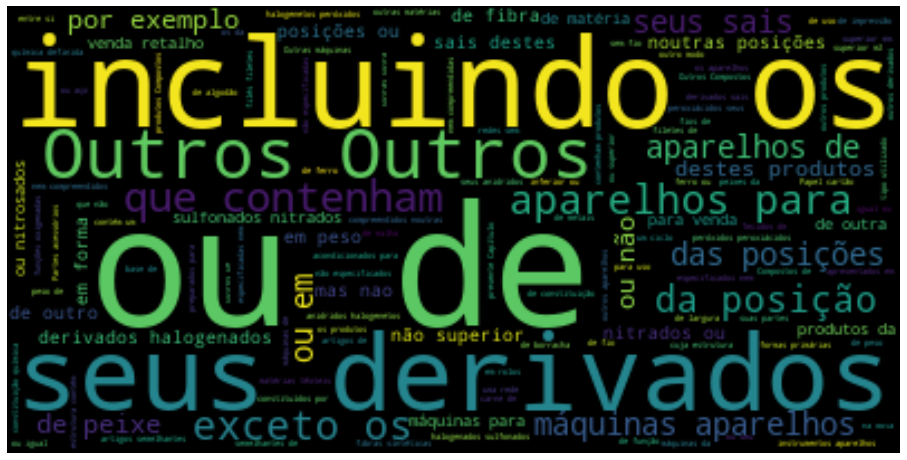

In [20]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(listaTECResumo))

# Display the generated image:
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

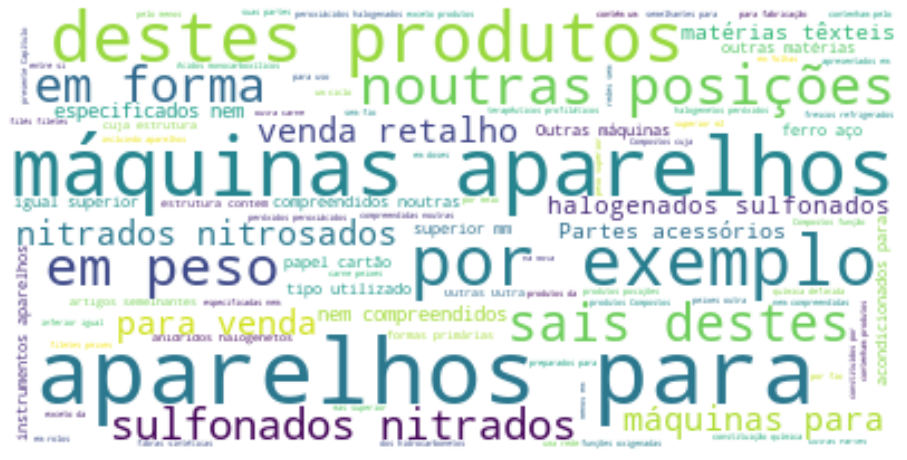

In [21]:
stopwords = set(STOPWORDS)
stopwords.update(['os', 'de', 'seus', 'que', "das", "derivados", 'não', 'posição',
                  'Outros', 'outro', 'Outro', 'ou'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(' '.join(listaTECResumo))
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Com o sklearn, fazer uma "busca" por uma palavra e confirmar sua pontuação em X e em Xtfidf

In [22]:
def get_index_documentos_palavra(X, palavra: str):
    indpalavra = vectorizer.vocabulary_[palavra]
    return np.argwhere(X[:, indpalavra].toarray() > 0), indpalavra

def show_dados_palavra(documentos, X, Xtfidf, palavra:str):
    indexes, indpalavra = get_index_documentos_palavra(X, palavra)
    for linha in indexes:
        inddocumento = linha[0]
        print(documentos[inddocumento])
        print(Xtfid[inddocumento, indpalavra])
        print(X[inddocumento, indpalavra])

In [23]:
indexes, indpalavra = get_index_documentos_palavra(X, 'arruelas')
print(indexes, indpalavra)

[[4756    0]
 [4803    0]
 [4804    0]
 [7097    0]
 [7098    0]
 [7099    0]
 [7100    0]
 [7101    0]
 [7102    0]
 [7103    0]
 [7104    0]
 [7105    0]
 [7106    0]
 [7107    0]
 [7108    0]
 [7205    0]
 [7206    0]
 [7207    0]
 [7208    0]
 [7209    0]
 [7293    0]] 936


In [24]:
show_dados_palavra(corpus, X, Xtfid, 'arruelas')

arruelas outras outras obras plastico obras outras materias posicoes 39 01 39 14
0.35209044782641996
1
perfis recauchutagem outras formas por exemplo varetas tubos perfis artigos por exemplo discos arruelas anilhas borracha vulcanizada
0.2874789688267496
1
outros outras formas por exemplo varetas tubos perfis artigos por exemplo discos arruelas anilhas borracha vulcanizada
0.3380702594906789
1
tira fundos artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos roscados rebites chavetas cavilhas contrapinos trocos arruelas anilhas incluindo pressao artigos semelhantes ferro fundido ferro aco
0.17171849214498303
1
outros parafusos madeira artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos roscados rebites chavetas cavilhas contrapinos trocos arruelas anilhas incluindo pressao artigos semelhantes ferro fundido ferro aco
0.18128620627348382
1
ganchos armelas pitoes artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos rosca

In [25]:
show_dados_palavra(listaTECResumo, X, Xtfid, 'arruelas')

3926.90.10 Arruelas -	Outras Outras obras de plástico e obras de outras matérias das posições 39.01 a 39.14.
0.35209044782641996
1
4006.10.00 -	Perfis para recauchutagem Outras formas (por exemplo, varetas, tubos, perfis) e artigos (por exemplo, discos, arruelas (anilhas*)), de borracha não vulcanizada.
0.2874789688267496
1
4006.90.00 -	Outros Outras formas (por exemplo, varetas, tubos, perfis) e artigos (por exemplo, discos, arruelas (anilhas*)), de borracha não vulcanizada.
0.3380702594906789
1
7318.11.00 --	Tira-fundos -	Artigos roscados: Parafusos, pinos ou pernos, roscados, porcas, tira-fundos, ganchos roscados, rebites, chavetas, cavilhas, contrapinos ou troços, arruelas (anilhas*) (incluindo as de pressão) e artigos semelhantes, de ferro fundido, ferro ou aço.
0.17171849214498303
1
7318.12.00 --	Outros parafusos para madeira -	Artigos roscados: Parafusos, pinos ou pernos, roscados, porcas, tira-fundos, ganchos roscados, rebites, chavetas, cavilhas, contrapinos ou troços, arruela

In [26]:
show_dados_palavra(listaTECResumo, X, Xtfid, 'bolsas')

3006.91.10 Bolsas para colostomia, ileostomia e urostomia --	Equipamentos identificáveis para ostomia -	Outros: Preparações e artigos farmacêuticos indicados na Nota 4 deste Capítulo.
0.25011218243894123
1
3923.21.10 De capacidade inferior ou igual a 1.000 cm3 --	De polímeros de etileno -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipientes, de plástico.
0.23243558246964305
1
3923.21.90 Outros --	De polímeros de etileno -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipientes, de plástico.
0.2530928044598255
1
3923.29.10 De capacidade inferior ou igual a 1.000 cm3 --	De outro plástico -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipie

### Conclusão TFIDF básico


Conforme demonstrado acima, é possível usar a matriz TFIDF para fazer "buscas" de classificação fiscal na TEC. Bastaria consultar os valores TFIDF de cada palavra, combinar, e exibir o "documento" (subitem da TEC) na ordem da pontuação obtida.

## Teste classificador (é possível predizer propabilidade de capítulo pela frase??)

In [28]:
y = [int(linha[:2]) for linha in listaTECResumo]

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split



In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.8043853165804385

In [31]:
arruela_plastico = vectorizer.transform(['arruelas plastico'])
print(arruela_plastico)

  (0, 936)	1
  (0, 7102)	1


In [32]:
clf.predict(arruela_plastico)

array([39])

In [33]:
bolsas_couro = vectorizer.transform(['bolsas couro'])
clf.predict(bolsas_couro)

array([42])

In [34]:
bolsas_plastico = vectorizer.transform(['bolsas plastico'])
clf.predict(bolsas_plastico)

array([39])

In [35]:
X_train, X_val, y_train, y_val = train_test_split(Xtfid, y, train_size=0.2)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5649174673564917

### Conclusão

Um classificador simples de capítulo, sem tunning, obteve 80% de acurácia para classificar o capítulo em uma base de treinamento com os documentos "descrição TEC completa" originais e predizeu corretamente duas expressões simples de busca.

## Melhorias

A grande fragilidade destas possibilidades de busca demonstradas (usar TF-IDF ou treinar classificadores) é que as palavras buscadas **precisam** estar no vocabulário. Para suprir este problema, são possíveis duas abordagens:

 * Usar um dicionário de sinônimos
 * Usar word embeddings e treinar um classificador com as embeddings (há um problema, como a base tem somente pouco mais de 10.000 linhas e este método envolve redes neurais, provavelmente não será possível treinar redes neurais)

In [14]:
import spacy
nlp = spacy.load("pt_core_news_sm")

tokens = nlp('arruelas plastico')

In [37]:
tokens

arruelas plastico

In [38]:
for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)


arruelas True 48.852642 True
plastico True 44.635536 True


In [39]:
tokens[0].vector

array([ 12.776641  ,  -1.119842  ,   4.2651024 ,  -2.842749  ,
         3.3195808 ,   2.4608216 ,  -8.104986  ,  -3.493442  ,
         5.909817  ,   0.86661834,   4.5411987 ,   1.7983334 ,
        -1.0091991 ,   2.2095509 ,  -5.637903  ,   5.109632  ,
        -2.7778745 ,  -3.3918538 ,  -2.3148997 ,   3.998908  ,
         8.419077  ,   1.0418421 ,   4.046485  ,  11.753028  ,
         1.8997545 ,  -4.8082795 ,  -5.912253  ,  -4.211125  ,
         2.3638601 ,   1.2602189 ,   2.5386271 ,  -5.6300163 ,
         5.386259  ,  -6.4208493 ,  -2.320203  ,  -3.84236   ,
         5.898923  ,   1.9341607 ,  -3.6678014 ,   2.350322  ,
        -3.1752608 ,   8.008952  ,   6.3870726 ,   1.5020604 ,
        -7.114374  ,  -3.8284023 ,  -4.3331447 ,   1.3941951 ,
         5.91114   ,   1.3393854 ,  -4.2787294 ,  -6.9610586 ,
        -3.0004895 ,  -2.647688  ,   1.2795722 ,  -1.1136105 ,
         0.6729131 ,   0.30478424,  -5.09515   ,   5.5853558 ,
        -5.595108  ,  -1.9178748 ,  -1.5372154 ,  -4.70

In [40]:
tokens[1].vector

array([  3.5684836 ,  -1.925127  ,   2.548791  ,   2.1013541 ,
         6.9125543 ,  -1.157139  ,  -6.622593  ,  -7.2240734 ,
        -1.7155715 ,   3.7684174 ,   6.43216   ,   1.0183662 ,
        -2.4061189 ,   0.11474317,   2.5214686 ,   2.13903   ,
        -3.5432763 ,   8.414198  ,  -1.1926565 ,   4.780589  ,
         3.593836  ,  -0.07527542,   8.304298  ,  11.163615  ,
        -3.867725  ,  -1.0414963 ,  -1.797202  ,   1.5334928 ,
         0.6240573 ,   0.5808499 , -10.1132    ,  -5.670818  ,
        -2.4708009 ,   7.4862423 ,   5.04297   ,  -1.0860665 ,
        -3.620214  ,  -7.5375605 ,  -1.2403668 ,   5.463876  ,
        -0.25288314,  -1.9830638 ,  -0.19251204,   4.277309  ,
        -3.1096148 ,   3.8140502 ,  -8.031469  ,   3.5311406 ,
        -2.001999  ,  -0.16415465,  -3.211752  ,  -2.2337608 ,
        -2.0819087 ,  11.009416  ,   5.780795  ,  -3.5985699 ,
        -6.363167  ,   7.7743864 ,   5.826233  ,   1.4261215 ,
        -0.29241854,  -0.7948784 ,  -3.2691932 ,  -5.43

In [41]:
from tensorflow import keras

In [42]:
for doc in corpus[:2]:
    print(doc)
    tokens = nlp(doc)
    print(tokens.vector)

reprodutores raca pura cavalos cavalos asininos muares vivos
[ 2.7953186   4.176491    0.8434681   0.16618407  2.6092045  -1.1901851
  1.2190241  -3.5989938   2.6585293  -0.5147271   1.0065104  -0.29725927
  4.733627    4.3019066  -0.15027341  3.0099165  -0.5224895   3.0358
  2.7201717   2.8244414   5.4925346  -2.0034776   1.8145082   3.3846107
 -4.968304   -4.7737427  -0.25154695 -0.31632626 -2.104146   -1.9016676
 -3.6670713  -6.180348    3.940358    2.0538275   3.5724587  -4.499657
  5.1532817  -4.3737025  -1.5316811  -5.238574    0.13850509  0.5397528
  0.2061348  -1.8139625  -2.1200364  -4.512215   -4.2306376   2.247971
 -1.7034007  -3.4776506   1.3487179  -7.4980073   2.0507877   2.012624
  4.8183413  -0.7075846   9.25494     0.6818701   4.022955   -0.9694898
 -1.1424521  -3.6532862  -1.9534218  -7.028407    7.2797275  -5.334967
  3.8741927   2.8014352   2.993805   -0.23742156  4.7158194  -5.1164284
 -3.7728276   1.474102   -2.6845472  -2.0615275   2.2942512  -4.497515
 -0.739318

In [43]:
for doc in corpus[:2]:
    print(doc)
    tokens = nlp(doc)
    for token in tokens:
        print(token.vector)

reprodutores raca pura cavalos cavalos asininos muares vivos
[ 6.64293242e+00  1.87291443e-01  6.24938774e+00  1.25831628e+00
  1.12645035e+01  1.62478197e+00 -6.70816994e+00 -1.23039436e+00
  5.05357218e+00 -3.12805176e+00  1.66952193e+00 -3.97077203e+00
  4.87114954e+00  7.86261654e+00 -6.47044659e+00  1.94734764e+00
  2.06741238e+00  6.61689878e-01  3.94642997e+00 -1.63302869e-02
  6.39751863e+00 -3.85731220e-01 -5.53474426e-01  3.19521689e+00
  1.31331623e-01 -1.11653461e+01 -1.57218754e+00 -5.52335083e-01
  1.86404061e+00 -2.52212238e+00 -4.66619825e+00 -7.23742867e+00
  8.59963608e+00  1.08069718e+00  6.40867996e+00 -8.20451927e+00
  5.25842619e+00 -9.63336372e+00 -2.79402876e+00  1.02870238e+00
  1.69568944e+00  4.14215183e+00 -3.32162738e+00  4.07819867e-01
 -6.81309938e+00 -9.28379536e+00 -2.13685131e+00  7.57637453e+00
  4.28763151e+00  3.81842184e+00 -5.71094632e-01 -1.06393709e+01
 -8.56875801e+00 -5.78028321e-01  5.24746656e+00  3.46253490e+00
  1.76879239e+00 -4.92994595e

In [44]:
embeddings = [nlp(doc).vector for doc in corpus]

In [45]:
len(embeddings)

10147

In [46]:
embeddings[0].shape

(96,)

In [47]:
embeddings[10].shape

(96,)

In [48]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

labels = encoder.fit_transform(y)

In [49]:
encoder.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

In [50]:
labels[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=96))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(len(encoder.classes_), activation='softmax'))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               49664     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                49248     
Total params: 361,568
Trainable params: 361,568
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])


In [54]:
model.fit(np.array(embeddings), labels, epochs=40)

Train on 10147 samples
Epoch 1/40
10147/10147 [==============================] - 4s 424us/sample - loss: 3.5296 - acc: 0.2956
Epoch 2/40
10147/10147 [==============================] - 1s 111us/sample - loss: 2.4273 - acc: 0.4515
Epoch 3/40
10147/10147 [==============================] - 1s 110us/sample - loss: 2.0178 - acc: 0.5393
Epoch 4/40
10147/10147 [==============================] - 1s 112us/sample - loss: 1.7407 - acc: 0.5889
Epoch 5/40
10147/10147 [==============================] - 1s 110us/sample - loss: 1.5256 - acc: 0.6313
Epoch 6/40
10147/10147 [==============================] - 1s 110us/sample - loss: 1.3607 - acc: 0.6658
Epoch 7/40
10147/10147 [==============================] - 1s 110us/sample - loss: 1.2210 - acc: 0.6969
Epoch 8/40
10147/10147 [==============================] - 1s 109us/sample - loss: 1.1165 - acc: 0.7279
Epoch 9/40
10147/10147 [==============================] - 1s 107us/sample - loss: 1.0172 - acc: 0.7472
Epoch 10/40
10147/10147 [=========================

In [55]:
y_pred = model.predict(np.array([nlp('arruelas plastico').vector]))

In [56]:
y_pred.argmax()

24

In [57]:
y_pred = model.predict(np.array([nlp('bolsas plastico').vector]))

In [58]:
y_pred.argmax()

71

In [59]:
y_pred = model.predict(np.array([nlp('bolsas couro').vector]))

In [60]:
y_pred.argmax()

60

# Conclusão final

Utilizando spacy para calcular o vetor completo da frase (em termos de word embeddings), a acurácia em relação à classificação do capítulo pela "TEC descrição completa" aumentou bastante em relação ao classificador "baseline" (de 81% para 94%). Curiosamente, nas frases de busca montadas, mais curtas, o classificador errou.

Isso mostra dois fatos:


- O classificador neural é mais poderoso e mais promissor
- Entretanto, até por ser mais poderoso, é tendente a sobrajuste e sensível à base e à arquitetura do treinamento


Estamos tratando de Recuperação de informação. A literatura demonstra que as abordagens tradicionais utilizando TF-IDF e especialmente a fórmula Okapi BM25 
Assim, para chegar a um classificador realmente adequado seria necessário:



- Extrair os embeddings de cada palavra de cada frase
- Montar uma rede convolucional ou recorrente que permitisse invariância de posição e independência do tamanho da frase
- Treinar estar rede, inclusive com data augmentation, por exemplo, extrair da matriz TF-IDF as palavras com maior pontuação de cada documento e, aleatoriamente, treinar com o documento completo ou com um subconjunto de palavras deste para simular *queries*. Idealmente, trocar também por vetores bem próximos
- Trabalhar na função de custo. Literatura 3 sugere o uso de uma função de custo em coseno, passando documentos de mesmo capítulo em redes siamesas, ao invés de apenas utilizar uma entrada única e um *softmax* na saída. Faz sentido, visto que estamos buscando aprender similaridades e não tão somente categorias



Referências:

Robertson, Stephen; Zaragoza, Hugo (2009). The Probabilistic Relevance Framework: BM25 and Beyond (PDF). NOW Publishers, Inc. ISBN 978-1-60198-308-4.

http://staff.city.ac.uk/~sb317/papers/foundations_bm25_review.pdf


Tie-Yan Liu. Learning to rank for Information Retrieval. Journal Foundations and Trends in Information Retrieval Volume 3 Issue 3, March 2009.

https://dl.acm.org/citation.cfm?id=1618304

Bhaskar Mitra1 and Nick Craswell2. An Introduction to Neural Information Retrieval. Microsoft Research.


https://www.microsoft.com/en-us/research/uploads/prod/2017/06/INR-061-Mitra-neuralir-intro.pdf


### Explorações adicionais.

Por questão de tempo e escopo do projeto, não desenvolveremos por ora as soluções previstas na conclusão. Abaixo,
apenas uma *sandbox* para iniciar esta exploração.

In [61]:
embeddings_complete = []
for doc in corpus:
    tokens = nlp(doc)
    doc_embedding = []
    for token in tokens:
        if token.has_vector:
            doc_embedding.append(token.vector)
    embeddings_complete.append(doc_embedding)
    

In [62]:
max_len = 0
min_len = 1000
avg_len = 0
for emb in embeddings_complete:
    size = len(emb)
    avg_len += size
    if size > max_len:
        max_len = size
    if size < min_len:
        min_len = size

avg_len = avg_len / len(embeddings_complete)

In [63]:
min_len

1

In [64]:
avg_len

23.768897210998325

In [65]:
max_len

98

In [66]:
print(len(embeddings_complete))

10147


In [67]:
print(embeddings_complete[0])

[array([ 6.64293242e+00,  1.87291443e-01,  6.24938774e+00,  1.25831628e+00,
        1.12645035e+01,  1.62478197e+00, -6.70816994e+00, -1.23039436e+00,
        5.05357218e+00, -3.12805176e+00,  1.66952193e+00, -3.97077203e+00,
        4.87114954e+00,  7.86261654e+00, -6.47044659e+00,  1.94734764e+00,
        2.06741238e+00,  6.61689878e-01,  3.94642997e+00, -1.63302869e-02,
        6.39751863e+00, -3.85731220e-01, -5.53474426e-01,  3.19521689e+00,
        1.31331623e-01, -1.11653461e+01, -1.57218754e+00, -5.52335083e-01,
        1.86404061e+00, -2.52212238e+00, -4.66619825e+00, -7.23742867e+00,
        8.59963608e+00,  1.08069718e+00,  6.40867996e+00, -8.20451927e+00,
        5.25842619e+00, -9.63336372e+00, -2.79402876e+00,  1.02870238e+00,
        1.69568944e+00,  4.14215183e+00, -3.32162738e+00,  4.07819867e-01,
       -6.81309938e+00, -9.28379536e+00, -2.13685131e+00,  7.57637453e+00,
        4.28763151e+00,  3.81842184e+00, -5.71094632e-01, -1.06393709e+01,
       -8.56875801e+00, 

In [72]:
Xemb = np.zeros((len(embeddings_complete), 98, 96))
for ind, emb in enumerate(embeddings_complete):
    embarray = np.array(emb[:98])
    Xemb[ind, :embarray.shape[0], :] = embarray

In [73]:
#with open('xemb.npy', 'bw') as xout:
#    np.save(xout, Xemb)

In [74]:
#with open('labels.npy', 'bw') as yout:
#    np.save(yout, labels)

In [1]:
import numpy as np
Xemb = np.load('xemb.npy', allow_pickle=True)

In [2]:
labels = np.load('labels.npy')

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Xemb, labels)

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input
model = Sequential()
model.add(Input(shape=(98, 96)))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D(7))
model.add(Flatten())
model.add(Dense(96, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 89, 128)           123008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 256)           65792     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                49248     
Total params: 238,048
Trainable params: 238,048
Non-trainable params: 0
________________________________________________

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [12]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Train on 7610 samples, validate on 2537 samples
Epoch 1/10
7610/7610 [==============================] - 2s 253us/sample - loss: 2.8833 - acc: 0.4652 - val_loss: 1.6359 - val_acc: 0.6307
Epoch 2/10
7610/7610 [==============================] - 1s 158us/sample - loss: 1.0348 - acc: 0.7694 - val_loss: 1.1203 - val_acc: 0.7351
Epoch 3/10
7610/7610 [==============================] - 1s 157us/sample - loss: 0.5194 - acc: 0.8926 - val_loss: 0.5787 - val_acc: 0.8723
Epoch 4/10
7610/7610 [==============================] - 1s 158us/sample - loss: 0.3244 - acc: 0.9361 - val_loss: 0.7385 - val_acc: 0.8163
Epoch 5/10
7610/7610 [==============================] - 1s 157us/sample - loss: 0.1745 - acc: 0.9678 - val_loss: 0.4797 - val_acc: 0.8944
Epoch 6/10
7610/7610 [==============================] - 1s 157us/sample - loss: 0.1208 - acc: 0.9787 - val_loss: 0.3349 - val_acc: 0.9322
Epoch 7/10
7610/7610 [==============================] - 1s 157us/sample - loss: 0.0574 - acc: 0.9883 - val_loss: 0.3525 - va

In [16]:
search = np.zeros((1, 98, 96))
search[0, 0, :] = np.array(nlp('arruelas').vector)
search[0, 1, :] = np.array(nlp('plastico').vector)
                        
y_pred = model.predict(search)
y_pred.argmax()

24

In [17]:
search = np.zeros((1, 98, 96))
search[0, 0, :] = np.array(nlp('brinquedos').vector)
search[0, 1, :] = np.array(nlp('bonecos').vector)
search[0, 2, :] = np.array(nlp('miniaturas').vector)
                        
y_pred = model.predict(search)
y_pred.argmax()

24

In [ ]:
search